# Fasanara Open Quant

---




***A casual excursion into allocation-based risk management surrounding Alpha Capture***



*Alpha Capture Systems (ACS) describe a set of commercial and private systems that track investment recommendations and their subsequent performance to create an alpha generating portfolio.* - **Steadfast Advisory Services Ltd, Kedge Capital Fund Management; EDHEC Business School**

In [ ]:
import re
import math 
import random
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from hmmlearn.hmm import GaussianHMM
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.covariance import graphical_lasso, GraphicalLassoCV


from dateutil.relativedelta import relativedelta

from google.colab import drive, files
drive.mount('/content/gdrive')

warnings.filterwarnings("ignore")

     |████████████████████████████████| 374 kB 5.3 MB/s 
Mounted at /content/gdrive


Including helper functions and quick portfolio evaluation methods

In [ ]:

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def date_format_func(x: str):
    try:
        return dt.datetime.strptime(x, '%d/%m/%Y')
    except ValueError:
        return dt.datetime.strptime(x, '%d/%m/%y')

def get_sharpe(df: pd.Series, rfr: float = 0.0):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    df.dropna()

    a_return = get_ann_return(df=df) - rfr
    a_std = get_ann_volatility(df=df)

    return a_return / a_std


def get_sortino(df: pd.Series, rfr: float = 0.0):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)
    df = df.dropna()
    df_chg = df.pct_change().dropna()

    a_return = get_ann_return(df=df) - rfr
    a_std = df_chg[df_chg < 0].iloc[:, 0].std() * np.sqrt(252)

    return a_return / a_std


def get_calmar(df: pd.Series, rfr: float = 0.0):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    a_return = get_ann_return(df=df)
    max_dd = get_max_drawdown(df=df)

    return (a_return - rfr) / max_dd


def get_ann_return(df: pd.Series):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    try:
        days_range = np.busday_count(df.index.min().strftime('%Y-%m-%d'), df.index.max().strftime('%Y-%m-%d'))
    except AttributeError:
        days_range = len(df)

    a_return = (df.iloc[-1, 0] / df.iloc[0, 0]) ** (252 / days_range) - 1

    return a_return


def get_ann_volatility(df: pd.Series):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    return df.pct_change().dropna().iloc[:, 0].std() * np.sqrt(252)


def get_max_drawdown(df: pd.Series):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)
    mdd = 0
    peak = df.iloc[0, 0]
    for x in df.iloc[:, 0]:
        if x > peak:
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd


def get_beta(df1: list, df2: list):
    min_idx: int = min(len(df1), len(df2))
    df1, df2 = df1[:min_idx], df1[:min_idx]
    beta = np.cov(df1, df2)[0][1] / np.var(df1)

    return beta

def get_information_ratio(portfolio: pd.Series, benchmark: pd.Series) -> float:
    assert len(portfolio.index) == len(benchmark.index)
    if not isinstance(portfolio, pd.Series):
      portfolio = portfolio.iloc[:, 0]
    if not isinstance(benchmark, pd.Series):
      benchmark = benchmark.iloc[:, 0]
      
    premium = get_ann_return(portfolio) - get_ann_return(benchmark)
    tracking_error = np.std((portfolio.pct_change().dropna().values -  benchmark.pct_change().dropna().values))
    return premium / tracking_error

def get_jensens_alpha(portfolio: pd.Series, benchmark: pd.Series, rfr: float = 0):
  assert len(portfolio.index) == len(benchmark.index)
  if not isinstance(portfolio, pd.Series):
    portfolio = portfolio.iloc[:, 0]
  if not isinstance(benchmark, pd.Series):
    benchmark = benchmark.iloc[:, 0]

  return get_ann_return(portfolio) - rfr - get_beta(portfolio.to_list(), benchmark.to_list()) * (get_ann_return(portfolio) - get_ann_return(benchmark))

def get_trenor_mazuy(portfolio: pd.Series, benchmark: pd.Series, rfr: float = 0):
    assert len(portfolio.index) == len(benchmark.index)
    if not isinstance(portfolio, pd.Series):
        portfolio = portfolio.iloc[:, 0]
    if not isinstance(benchmark, pd.Series):
        benchmark = benchmark.iloc[:, 0]

    portfolio_beta = get_beta(portfolio.to_list(), benchmark.to_list())

    benchmark_ret = get_ann_return(benchmark)
    portfolio_ret = get_ann_return(portfolio)

    benchmark_risk_premium = benchmark_ret - rfr
    portfolio_risk_premium = portfolio_ret - rfr

    alpha = get_jensens_alpha(portfolio=portfolio, benchmark=benchmark, rfr=rfr)

    return (portfolio_risk_premium - portfolio_beta * (benchmark_risk_premium) - alpha) / benchmark_risk_premium ** 2

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

def get_port_stats(hist_data: pd.DataFrame, col_label: str):
  idx = ['return', 'volatility', 'sharpe', 'sortino', 'calmar', 'drawdown']

  return pd.DataFrame({col_label: [get_ann_return(hist_data), get_ann_volatility(hist_data), get_sharpe(hist_data, rfr=rfr), 
                                   get_sortino(hist_data, rfr=rfr), get_calmar(hist_data, rfr=rfr), get_max_drawdown(hist_data)]}, index=idx)


class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=5):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

**Closed-form classic solutions for portfolio optimization**



Global Minimum Variance: Solve for minimum variance given that the summation of 
weights (including negative weights) equal one.

Maximizing for Absolute Returns: Solve for maximum absolute returns given that the summation of weights equal one.

Maximizing Sharpe Ratio: Dual constraint problem. Solving for highest absolute return given a certain risk level while solving for minimum risk givena return level with the summation of weights equaling one. 

In [ ]:

class PortfolioOptimization:
    def __init__(self, hist_data: pd.DataFrame, regularization: bool = False):
        """
        param: hist_data: pd.DataFrame -> Input historical price series (indexed) data of each asset with the columns
        as the asset name or a recognizable name to the asset thereof.
        """

        self.rfr = 0.015
        self.assets = hist_data.columns.to_list()
        self.one_vec = np.ones(len(self.assets))

        self.hist_data = hist_data
        self.hist_return = np.log(self.hist_data / self.hist_data.shift()).dropna()

        # find historical mean, covariance, and correlation
        self.hist_mean = self.hist_return.mean(axis=0).to_frame()
        self.hist_mean.columns = ['mu']

        if regularization:
            self.hist_cov = GraphicalLassoCV(max_iter=100, cv=5, alphas=[n / 10 for n in range(0, 100)]).fit(
                self.hist_return).covariance_
        else:
            self.hist_cov = self.hist_return.cov()

        self.hist_cov_inv = - np.linalg.inv(self.hist_cov)

        self.hist_corr = self.hist_return.corr()

    def equal_weight(self, ret_stats: bool = False, ret_weights: bool = False):
        w_eq = self.one_vec / len(self.one_vec)
        price_series = pd.Series(np.exp(np.dot(w_eq.T, self.hist_return.T).cumsum()))
        ann_return = get_ann_return(price_series)
        ann_vol = get_ann_volatility(price_series)
        sharpe = get_sharpe(price_series)
        sortino = get_sortino(pd.Series(price_series), rfr=self.rfr)
        calmar = get_calmar(pd.Series(price_series), rfr=self.rfr)
        drawdown = get_max_drawdown(pd.Series(price_series))

        if ret_weights:
            return w_eq

        print('Equal Weights: ')
        with pd.option_context('display.max_rows', None, 'display.max_columns',
                               None):  # more options can be specified also
            print(pd.DataFrame(columns=self.assets, data=[w_eq], index=[0]))
        print('---------------------')
        print(f'equal_weight_expected_return: {ann_return}')
        print(f'equal_weight_vol: {ann_vol}')
        print(f'equal_weight_sharpe_ratio: {sharpe}')
        print('---------------------')

        if ret_stats:
            return pd.DataFrame({'return': ann_return, 'volatility': ann_vol, 'sharpe': sharpe,
                                 'sortino': sortino, 'calmar': calmar, 'drawdown': drawdown}, index=[0])

    def gmv(self, ret_stats: bool = False, ret_weights: bool = False):
        one_vec = np.ones(len(self.assets))
        w_gmv = np.dot(self.hist_cov_inv, one_vec) / (np.dot(np.transpose(one_vec), np.dot(self.hist_cov_inv, one_vec)))
        w_gmv_df = pd.DataFrame(data=w_gmv).transpose()
        w_gmv_df.columns = self.assets
        stddev_gmv = np.sqrt(np.dot(w_gmv.T, np.dot(self.hist_cov, w_gmv))) * np.sqrt(252)

        mu_gmv = (np.dot(w_gmv_df, self.hist_mean.to_numpy()) * 252)[0][0]
        sharpe_gmv = ((mu_gmv - self.rfr) / stddev_gmv)

        if ret_weights:
            return w_gmv

        print('Optimized Global Minimum Variance Weights: ')
        with pd.option_context('display.max_rows', None, 'display.max_columns',
                               None):  # more options can be specified also
            print(w_gmv_df)
        print('---------------------')
        print(f'gmv_expected_return: {mu_gmv}')
        print(f'gmv_vol: {stddev_gmv}')
        print(f'gmv_sharpe_ratio: {sharpe_gmv}')
        print('---------------------')

        if ret_stats:
            price_series = np.exp(np.dot(w_gmv.T, self.hist_return.T).cumsum())
            sortino = get_sortino(pd.Series(price_series), rfr=self.rfr)
            calmar = get_calmar(pd.Series(price_series), rfr=self.rfr)
            drawdown = get_max_drawdown(pd.Series(price_series))

            return pd.DataFrame({'return': mu_gmv, 'volatility': stddev_gmv, 'sharpe': sharpe_gmv,
                                 'sortino': sortino, 'calmar': calmar, 'drawdown': drawdown}, index=[0])

    def max_return(self, ret_stats: bool = False, ret_weights: bool = False):
        mu_o = np.max(self.hist_mean).item()  # MCD
        A = np.matrix([[(np.dot(self.hist_mean.T, np.dot(self.hist_cov_inv, self.hist_mean))).item(),
                        (np.dot(self.hist_mean.T, np.dot(self.hist_cov_inv, self.one_vec))).item()],
                       [(np.dot(self.hist_mean.T, np.dot(self.hist_cov_inv, self.one_vec))).item(),
                        (np.dot(self.one_vec.T, np.dot(self.hist_cov_inv, self.one_vec))).item()]])
        B = np.hstack([np.array(self.hist_mean), self.one_vec.reshape(len(self.assets), 1)])
        y = np.matrix([mu_o, 1]).T
        w_max_ret = np.dot(np.dot(np.dot(self.hist_cov_inv, B), np.linalg.inv(A)), y)
        w_max_ret_df = pd.DataFrame(w_max_ret).T
        w_max_ret_df.columns = self.assets

        if ret_weights:
            return w_max_ret

        mu_absolute = (np.dot(w_max_ret_df, self.hist_mean.to_numpy()) * 252)[0][0]
        stddev_absolute = (np.sqrt(np.dot(w_max_ret_df, np.dot(self.hist_cov, w_max_ret_df.T))) * np.sqrt(252))[0][0]
        sharpe_absolute = ((mu_absolute - self.rfr) / stddev_absolute)

        print('Optimized Absolute Return Weights: ')
        with pd.option_context('display.max_rows', None, 'display.max_columns',
                               None):  # more options can be specified also
            print(w_max_ret_df)
        print('---------------------')
        print(f'absolute_expected_return: {mu_absolute}')
        print(f'absolute_vol: {stddev_absolute}')
        print(f'absolute_sharpe_ratio: {sharpe_absolute}')
        print('---------------------')

        if ret_stats:
            price_series = np.exp(np.dot(np.array(w_max_ret)[:, 0].T, self.hist_return.T).cumsum())
            sortino = get_sortino(pd.Series(price_series), rfr=self.rfr)
            calmar = get_calmar(pd.Series(price_series), rfr=self.rfr)
            drawdown = get_max_drawdown(pd.Series(price_series))

            return pd.DataFrame(data={'return': mu_absolute, 'volatility': stddev_absolute, 'sharpe': sharpe_absolute,
                                      'sortino': sortino, 'calmar': calmar, 'drawdown': drawdown}, index=[0])

    def max_sharpe(self, ret_stats: bool = False, ret_weights: bool = False):
        w_sharpe = np.dot(self.hist_cov_inv, self.hist_mean.to_numpy() - self.rfr / 252) / np.dot(self.one_vec,
                                                                                                  np.dot(
                                                                                                      self.hist_cov_inv,
                                                                                                      self.hist_mean.to_numpy() - self.rfr / 252))
        w_sharpe_df = pd.DataFrame(w_sharpe).T
        w_sharpe_df.columns = self.assets

        if ret_weights:
            return w_sharpe

        mu_sharpe = (np.dot(w_sharpe.T, self.hist_mean.to_numpy()) * 252)[0][0]
        stddev_sharpe = (np.sqrt(np.dot(w_sharpe.T, np.dot(self.hist_cov, w_sharpe))) * np.sqrt(252))[0][0]
        sharpe_sharpe = ((mu_sharpe - self.rfr) / stddev_sharpe)

        print('Optimized Sharpe Weights: ')
        with pd.option_context('display.max_rows', None, 'display.max_columns',
                               None):  # more options can be specified also
            print(w_sharpe_df)
        print('------------------------------')
        print(f'sharpe_expected_return: {mu_sharpe}')
        print(f'sharpe_vol: {stddev_sharpe}')
        print(f'sharpe_sharpe_ratio: {sharpe_sharpe}')
        print('---------------------')

        if ret_stats:
            price_series = np.exp(np.dot(w_sharpe.T, self.hist_return.T).cumsum())
            sortino = get_sortino(pd.Series(price_series), rfr=self.rfr)
            calmar = get_calmar(pd.Series(price_series), rfr=self.rfr)
            drawdown = get_max_drawdown(pd.Series(price_series))

            return pd.DataFrame({'return': mu_sharpe, 'volatility': stddev_sharpe, 'sharpe': sharpe_sharpe,
                                 'sortino': sortino, 'calmar': calmar, 'drawdown': drawdown}, index=[0])

In [ ]:
rfr = .015

`**We assume a risk-free rate of 1.5% (approximate yield of 10Y treasury note)**`

In [ ]:
total_portfolio_rets=pd.read_csv(r'gdrive/My Drive/quant_returns.csv')
total_portfolio_rets = total_portfolio_rets.rename(columns={'DATE': 'date', 'SMTR': 'SMRT', 'ALTM': 'ATLP'}, inplace=False) \
    .set_index('date', drop=True, inplace=False).dropna(how='all', axis=0).apply(
    lambda x: x.apply(lambda y: float(re.sub('%', '', str(y))) / 100)).sort_index(ascending=True)
total_portfolio_rets =  total_portfolio_rets.loc[:, ['SMRT',	'VOLT', 'LIBR',	'AXYO',	'BUZZ',	'SAMM',	'ATLP',	'ALBE',	'TOGG',	'BRAM']]

total_portfolio_rets.index = list(map(lambda x: date_format_func(x), total_portfolio_rets.index))

start_index = pd.DataFrame(data={col: [0] for col in total_portfolio_rets.columns},
                            index=[total_portfolio_rets.index.min() - dt.timedelta(days=1)])

total_portfolio_rets = pd.concat([total_portfolio_rets, start_index], axis=0).sort_index(ascending=True) 

# total_portfolio_rets[total_portfolio_rets != 0] = total_portfolio_rets[total_portfolio_rets != 0] - .0005 # 5bps 
total_portfolio_rets[total_portfolio_rets.loc[(total_portfolio_rets.index < dt.datetime(2021, 6, 1)), :].apply(lambda x: x.apply(lambda y: True if y < 0 else False))] = \
 total_portfolio_rets[total_portfolio_rets.loc[(total_portfolio_rets.index < dt.datetime(2021, 6, 1)), :].apply(lambda x: x.apply(lambda y: True if y < 0 else False))] * 1.5 # backtest penalization factor excluding live results 

total_portfolio_index = total_portfolio_rets.apply(lambda x: x + 1).cumprod()


The columns of our portfolio frame are the individual strategies both in-house and external. The values are the index levels since 2015 till the recent present with approximately 9/10ths of the return values coming from backtests with simulated slippage and commissions included.

*Loading S&P last-price values for comparison*

In [ ]:
sp_index = pd.read_csv(r'gdrive/My Drive/es1.csv', index_col=0)
sp_index.index = list(map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'), sp_index.index))
sp_index = sp_index.loc[sp_index.index > dt.datetime(2015, 1, 1), :].sort_index(ascending=True, inplace=False)
sp_add_on = pd.DataFrame(data=sp_index.iloc[0,0], columns=['last_price'], index=[dt.datetime(2015, 1, 1)])
sp_index = pd.concat([sp_add_on, sp_index], axis=0)
sp_index = sp_index.loc[total_portfolio_index.index, :].rename(columns={'last_price': 'SPX'}).loc[:, 'SPX']

sp_index_rets = sp_index.reset_index(drop=True).pct_change()

In [ ]:
ytd = False
if ytd:
  total_portfolio_index = total_portfolio_index.loc[total_portfolio_index.index >= dt.datetime(2021, 1, 1), :] # examine portfolio relations for a period where the proportion of OOS or live results is larger


In [ ]:
strat_corr = pd.concat([total_portfolio_index.pct_change().dropna(), sp_index.pct_change().dropna()], axis=1).corr()
strat_corr.style.background_gradient(cmap='RdPu')

,SMRT,VOLT,LIBR,AXYO,BUZZ,SAMM,ATLP,ALBE,TOGG,BRAM,SPX
SMRT,1.000000,0.062850,0.356740,-0.055736,0.018339,0.011651,0.020480,0.104263,-0.008176,0.006378,0.323454
VOLT,0.062850,1.000000,0.300608,-0.034440,0.005448,0.015337,0.077226,0.078162,0.098289,0.020703,0.307037
LIBR,0.356740,0.300608,1.000000,-0.082886,0.017982,-0.044852,0.010723,0.210948,0.263338,-0.009729,0.704056
AXYO,-0.055736,-0.034440,-0.082886,1.000000,-0.014625,0.042577,-0.031624,-0.020558,-0.030086,-0.033705,-0.073554
BUZZ,0.018339,0.005448,0.017982,-0.014625,1.000000,0.105050,0.010253,-0.038864,-0.037551,0.014818,0.034898
SAMM,0.011651,0.015337,-0.044852,0.042577,0.105050,1.000000,0.057057,-0.018271,-0.006203,0.019078,-0.063127
ATLP,0.020480,0.077226,0.010723,-0.031624,0.010253,0.057057,1.000000,0.061698,0.084494,0.026484,0.028064
ALBE,0.104263,0.078162,0.210948,-0.020558,-0.038864,-0.018271,0.061698,1.000000,0.092022,0.008345,0.168856
TOGG,-0.008176,0.098289,0.263338,-0.030086,-0.037551,-0.006203,0.084494,0.092022,1.000000,0.005506,0.364198
BRAM,0.006378,0.020703,-0.009729,-0.033705,0.014818,0.019078,0.026484,0.008345,0.005506,1.000000,-0.004455


In [ ]:
closed_form_opt = PortfolioOptimization(hist_data=total_portfolio_index, regularization=True)

eq = closed_form_opt.equal_weight(ret_stats=True)
gmv = closed_form_opt.gmv(ret_stats=True)
max_ret = closed_form_opt.max_return(ret_stats=True)
max_sharpe = closed_form_opt.max_sharpe(ret_stats=True)
max_sharpe_weights = closed_form_opt.max_sharpe(ret_weights=True)

Equal Weights: 
   SMRT  VOLT  LIBR  AXYO  BUZZ  SAMM  ATLP  ALBE  TOGG  BRAM
0   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1
---------------------
equal_weight_expected_return: 0.02341573059866775
equal_weight_vol: 0.039689490807721245
equal_weight_sharpe_ratio: 0.589973066475129
---------------------
Optimized Global Minimum Variance Weights: 
       SMRT      VOLT      LIBR      AXYO      BUZZ      SAMM      ATLP  \
0  0.069839  0.024945 -0.004242  0.074624  0.225681  0.284676  0.032094   

       ALBE      TOGG      BRAM  
0  0.037094  0.075956  0.179334  
---------------------
gmv_expected_return: 0.05057697330395087
gmv_vol: 0.026163422268114273
gmv_sharpe_ratio: 1.3597981540552906
---------------------
Optimized Absolute Return Weights: 
      SMRT      VOLT      LIBR      AXYO      BUZZ      SAMM     ATLP  \
0  0.10043  0.057329 -0.008956 -0.046234  0.100297  0.548653 -0.01246   

       ALBE      TOGG      BRAM  
0 -0.046054  0.037722  0.269274  
----------------

In [ ]:
summary_stats = pd.concat([eq, gmv, max_ret, max_sharpe], axis=0).reset_index(drop=True).T
obj_func = ['Equal Weight', 'GMV', 'ABS Return', 'Max Sharpe']
summary_stats = summary_stats.rename(columns={col: new_col for new_col, col in zip(obj_func, summary_stats.columns)})
summary_stats.loc[['return', 'volatility', 'drawdown'], :] = (summary_stats.T.loc[:, ['return', 'volatility', 'drawdown']] * 100).values.T # scaling by return/vol/drawdown by 100 
summary_stats

,Equal Weight,GMV,ABS Return,Max Sharpe
return,2.341573,5.057697,11.242256,19.612770
volatility,3.968949,2.616342,3.449845,5.903404
sharpe,0.589973,1.359798,2.823969,3.068191
sortino,0.286281,2.013205,4.275062,5.202681
calmar,0.113098,1.214662,1.775283,1.979907
drawdown,7.441085,3.021994,5.837308,10.153838


Plotting Optimization Comparison Radar (Polar Coordinates for tick distance)

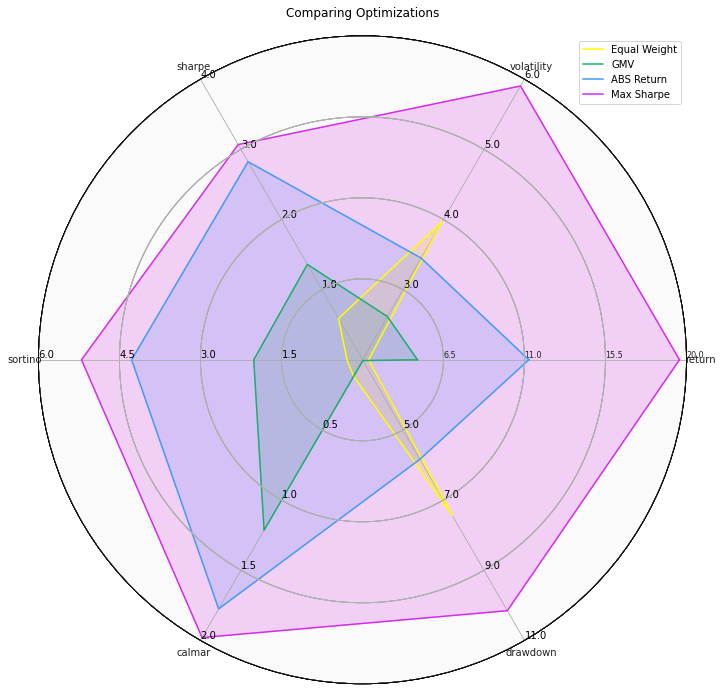

In [ ]:
variables = ('return', 'volatility', 'sharpe', 'sortino', 'calmar', 'drawdown')

ranges = [(math.floor(min(summary_stats.loc[row, :])), math.ceil(max(summary_stats.loc[row, :]))) for row in summary_stats.index]

fig1 = plt.figure(figsize=(10, 10))

opt_methods = ['Equal Weight', 'GMV', 'ABS Return', 'Max Sharpe']
colors = ['#FFFF00', '#1aaf6c', '#429bf4', '#d42cea']

for col, label, color in zip(summary_stats.columns,  opt_methods, colors):
  radar = ComplexRadar(fig1, variables, ranges)
  radar.plot(summary_stats.loc[:, col].values, color=color, label=label)
  radar.fill(summary_stats.loc[:, col].values, color=color, alpha=0.2)
radar.ax.tick_params(colors='#222222')
radar.ax.tick_params(axis='y', labelsize=8)

radar.ax.grid(color='#AAAAAA')
radar.ax.set_facecolor('#FAFAFA')
radar.ax.legend()


radar.ax.set_title('Comparing Optimizations', y=1.02)


plt.show()    

**Forward-Walk Analysis**


Assuming the following:
- 30% cap for internal models and a 15% cap for external models.
- Smallest increment change in weighting of 5% of the total portfolio 



In [ ]:
lookback_months = 6
rebalancing_periods = 1

ew_data = np.zeros(len(total_portfolio_index.columns))
gmv_data = np.zeros(len(total_portfolio_index.columns))
max_ret_data = np.zeros(len(total_portfolio_index.columns))
max_sharpe_data = np.zeros(len(total_portfolio_index.columns))

ew_weights, gmv_weights, max_ret_weights, max_sharpe_weights = [], [], [], []

for date in [total_portfolio_index.index.min() + relativedelta(months=lookback_months) + relativedelta(months=month) for month in range(diff_month(total_portfolio_index.index.max(), total_portfolio_index.index.min() + relativedelta(months=lookback_months)))]:
  opt_slice = total_portfolio_rets.loc[(total_portfolio_rets.index < date) & (total_portfolio_rets.index >= date - relativedelta(months=lookback_months)), :].apply(lambda x: x + 1).cumprod()
  opt_slice = opt_slice.loc[:, opt_slice.std(axis=0) != 0]
  total_port_slice = total_portfolio_rets.loc[(total_portfolio_rets.index >= date) & (total_portfolio_rets.index < date + relativedelta(months=rebalancing_periods)), :]
  total_port_slice = total_port_slice.loc[:, opt_slice.columns].replace(np.inf, np.nan).replace(np.nan, 0)

  try:
    opt_port_lookback = PortfolioOptimization(hist_data=opt_slice, regularization=True)
  except:
    opt_port_lookback = PortfolioOptimization(hist_data=opt_slice, regularization=False)

  equal_weight = opt_port_lookback.equal_weight(ret_weights=True)
  gmv = opt_port_lookback.gmv(ret_weights=True)
  max_ret = opt_port_lookback.max_return(ret_weights=True)
  max_sharpe = opt_port_lookback.max_sharpe(ret_weights=True)
  
  # setting negative weights to 0
  equal_weight[equal_weight < 0] = 0
  gmv[gmv < 0] = 0
  max_ret[max_ret < 0] = 0
  max_sharpe[max_sharpe < 0] = 0
  
  # # creating minimum increments of 5% of portfolio 
  # adapted_sign = lambda x: 1 if x >= 0 else -1
  # gmv[gmv < 0] = 0
  # max_ret[max_ret < 0] = 0
  # max_sharpe[max_sharpe < 0] = 0

  # scaling portfolio to 1x leverage
  equal_weight = np.apply_along_axis(lambda x: x * 1 / sum(x), 0, equal_weight)
  gmv = np.apply_along_axis(lambda x: x * 1 / sum(x), 0, gmv)
  max_ret = max_ret / sum(max_ret)
  max_sharpe = max_sharpe / sum(max_sharpe)
  
  # capping internal strategy's marginal weight at 50%
  equal_weight[:3][equal_weight[:3] > .5] = .5
  gmv[:3][gmv[:3] > .5] = .5
  max_ret[:3][max_ret[:3] > .5] = .5
  max_sharpe[:3][max_sharpe[:3] > .5] = .5

  # capping external strategy's marginal weight at 30%
  equal_weight[3:][equal_weight[3:] > .3] = .3
  gmv[3:][gmv[3:] > .3] = .3
  max_ret[3:][max_ret[3:] > .3] = .3
  max_sharpe[3:][max_sharpe[3:] > .3] = .3
  


  
  ew_weights.append(pd.DataFrame(data=np.vstack([equal_weight] * len(total_port_slice.index)), index=total_port_slice.index))
  gmv_weights.append(pd.DataFrame(data=np.vstack([gmv] * len(total_port_slice.index)), index=total_port_slice.index))
  max_ret_weights.append(pd.DataFrame(data=np.vstack([max_ret.T] * len(total_port_slice.index)), index=total_port_slice.index))
  max_sharpe_weights.append(pd.DataFrame(data=np.vstack([max_sharpe.T] * len(total_port_slice.index)), index=total_port_slice.index))


  ew_rets = np.matmul(equal_weight, total_port_slice.T.values)
  gmv_rets = np.matmul(gmv, total_port_slice.T.values)
  max_max_rets = np.matmul(np.array(max_ret)[:, 0], total_port_slice.T.values)
  max_sharpe_rets = np.matmul(np.array(max_sharpe)[:, 0], total_port_slice.T.values)

  ew_data = np.concatenate((ew_data, ew_rets))
  gmv_data = np.concatenate((gmv_data, gmv_rets))
  max_ret_data = np.concatenate((max_ret_data, max_max_rets))
  max_sharpe_data = np.concatenate((max_sharpe_data, max_sharpe_rets))
  

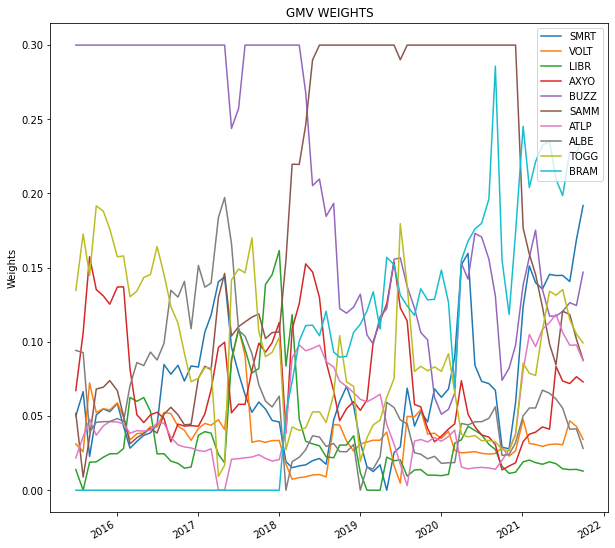

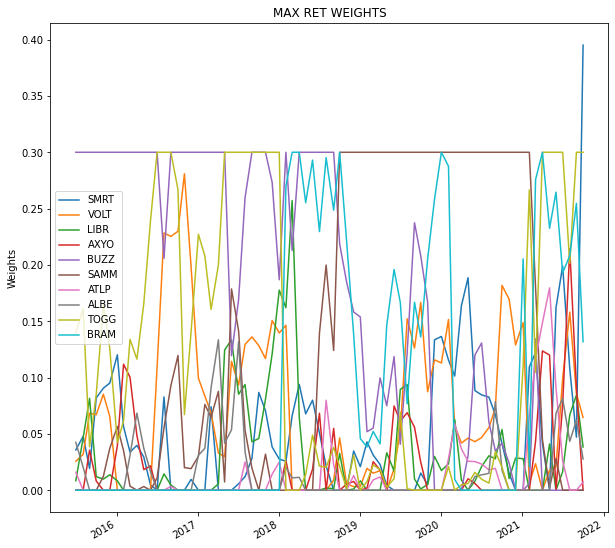

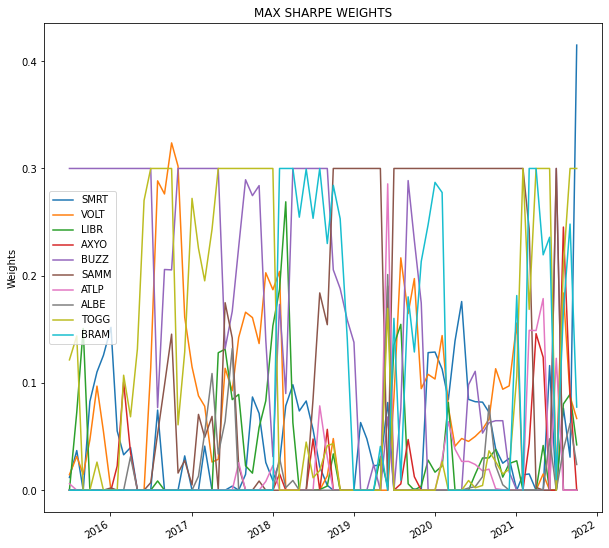

In [ ]:
for var_name in ['gmv_weights', 'max_ret_weights', 'max_sharpe_weights']:
  locals()[var_name] = pd.concat(locals()[var_name]).replace(np.nan, 0)
  locals()[var_name].columns = total_port_slice.columns
  locals()[var_name] = locals()[var_name].drop_duplicates()
  ax = locals()[var_name].plot(figsize=(10, 10))
  ax.set_ylabel("Weights")
  ax.set_title(' '.join(var_name.split('_')).upper())
  ax.plot()

# file_name = 'max_sharpe_weights.csv'
# max_sharpe_weights.to_csv(file_name)
# files.download(file_name)

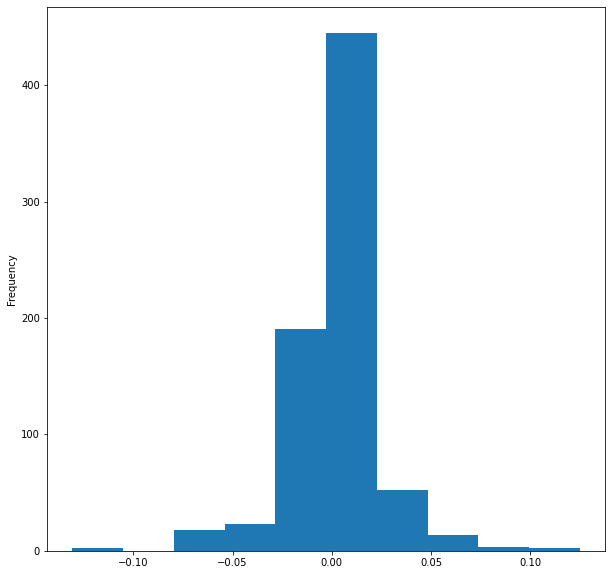

In [ ]:
gmv_weights.diff().stack().plot.hist(figsize=(10, 10))

[]

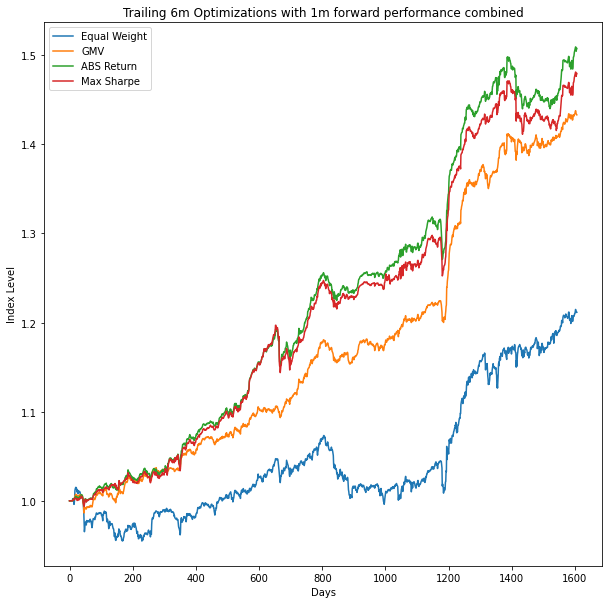

In [ ]:
ew_data = pd.Series(ew_data).rename('Equal Weight').replace(np.nan, 0).apply(lambda x: x + 1).cumprod()
gmv_data = pd.Series(gmv_data).rename('GMV').replace(np.nan, 0).apply(lambda x: x + 1).cumprod()
max_ret_data = pd.Series(max_ret_data).rename('ABS Return').replace(np.nan, 0).apply(lambda x: x + 1).cumprod()
max_sharpe_data = pd.Series(max_sharpe_data).rename('Max Sharpe').replace(np.nan, 0).apply(lambda x: x + 1).cumprod()


# sp_index_rets.iloc[len(sp_index) -len(max_sharpe_data):, :].reset_index(drop=True).apply(lambda x: x +1).cumprod()
lookahead_plot_df = pd.concat([ew_data, gmv_data, max_ret_data, max_sharpe_data], axis=1)
# lookahead_plot_df.index = total_portfolio_index[total_portfolio_index.index >= total_portfolio_index.index.min() + relativedelta(months=6)].index
lookahead_plot_df.index.name = 'Days'

ax = lookahead_plot_df.plot(figsize =(10, 10))
ax.set_ylabel("Index Level")
ax.set_title('Trailing 6m Optimizations with 1m forward performance combined')
plt.plot()

In [ ]:
idx = ['return', 'volatility', 'sharpe', 'sortino', 'calmar', 'drawdown']

lookback_df = pd.concat([
  pd.DataFrame({'Equal Weight': [get_ann_return(ew_data), get_ann_volatility(ew_data), get_sharpe(ew_data, rfr=rfr), get_sortino(ew_data, rfr=rfr), get_calmar(ew_data, rfr=rfr), get_max_drawdown(ew_data)]}, index=idx),
  pd.DataFrame({'GMV': [get_ann_return(gmv_data), get_ann_volatility(gmv_data), get_sharpe(gmv_data, rfr=rfr), get_sortino(gmv_data, rfr=rfr), get_calmar(gmv_data, rfr=rfr), get_max_drawdown(gmv_data)]}, index=idx),
  pd.DataFrame({'ABS Return': [get_ann_return(max_ret_data), get_ann_volatility(max_ret_data), get_sharpe(max_ret_data, rfr=rfr), get_sortino(max_ret_data, rfr=rfr), get_calmar(max_ret_data, rfr=rfr), get_max_drawdown(max_ret_data)]}, index=idx),
  pd.DataFrame({'Max Sharpe': [get_ann_return(max_sharpe_data), get_ann_volatility(max_sharpe_data), get_sharpe(max_sharpe_data, rfr=rfr), get_sortino(max_sharpe_data, rfr=rfr), get_calmar(max_sharpe_data, rfr=rfr), get_max_drawdown(max_sharpe_data)]}, index=idx),
], axis=1)

lookback_df.loc[['return', 'volatility', 'drawdown'], :] = (lookback_df.T.loc[:, ['return', 'volatility', 'drawdown']] * 100).values.T # scaling by return/vol/drawdown by 100 

lookback_df


,Equal Weight,GMV,ABS Return,Max Sharpe
return,3.054122,5.804876,6.647941,6.333881
volatility,4.097211,2.552202,3.013183,3.186388
sharpe,0.379312,1.686730,1.708473,1.517041
sortino,0.516374,2.603989,2.071490,1.751250
calmar,0.216095,1.855591,1.325743,1.087739
drawdown,7.191845,2.319949,3.883060,4.443969


**Monte Carlo Weight Generation**

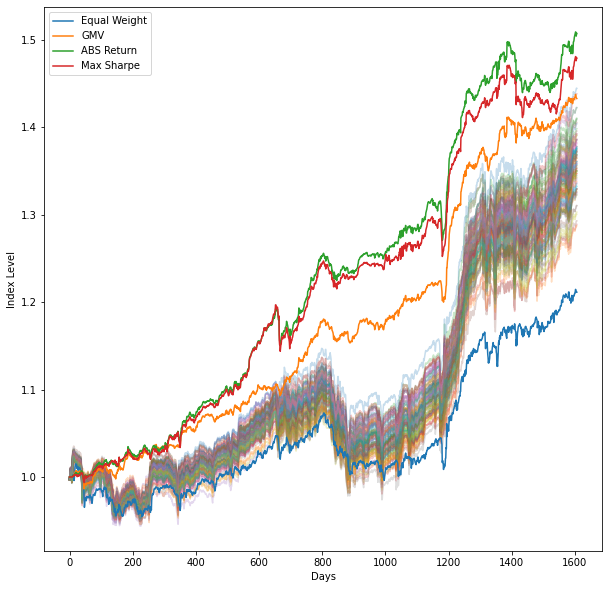

In [ ]:

external_cols = len(total_portfolio_rets.columns[3:])
internal_cols = 3

frame_len = len(ew_data)
mc_trials = []
for n in range(100):
  rand_vals = np.concatenate((np.random.uniform(low=0.1, high=.25, size=(len(total_portfolio_rets),internal_cols)),
              np.random.uniform(low=0.05, high=.5 / external_cols, size=(len(total_portfolio_rets),external_cols))), axis=1)

  rand_vals = np.apply_along_axis(lambda x: x * 1 / sum(x), 1, rand_vals)
  rand_vals = rand_vals[len(rand_vals) - frame_len:, :]

  mc_iter = pd.DataFrame(rand_vals *  total_portfolio_rets.iloc[len(total_portfolio_rets) - len(rand_vals):, :].values).sum(axis=1).apply(lambda x: x + 1).cumprod()

  mc_iter.plot(figsize=(10, 10), alpha=.25)
  mc_trials.append(mc_iter.values)


for var_name in ['ew_data', 'gmv_data', 'max_ret_data', 'max_sharpe_data']:
  ax = locals()[var_name].plot(figsize=(10, 10))

ax.set_xlabel('Days')
ax.set_ylabel('Index Level')
leg = ax.legend(['Equal Weight', 'GMV', 'ABS Return', 'Max Sharpe'])
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.show()


In [ ]:
mc_df = pd.concat([get_port_stats(hist_data=pd.DataFrame(np.average(mc_trials,axis=0)), col_label='Monte Carlo Avg'),
           get_port_stats(hist_data=pd.DataFrame(np.max(mc_trials, axis=0)), col_label='Monte Carlo Max'),
           get_port_stats(hist_data=pd.DataFrame(np.min(mc_trials, axis=0)), col_label='Monte Carlo Min'),
           get_port_stats(hist_data=pd.DataFrame(np.median(mc_trials,axis=0)), col_label='Monte Carlo Median')], axis=1)

mc_df.loc[['return', 'volatility', 'drawdown'], :] = (mc_df.T.loc[:, ['return', 'volatility', 'drawdown']] * 100).values.T # scaling by return/vol/drawdown by 100 

mc_df

,Monte Carlo Avg,Monte Carlo Max,Monte Carlo Min,Monte Carlo Median
return,5.005398,5.979069,4.095968,5.025061
volatility,5.491228,5.563181,5.574704,5.478208
sharpe,0.638363,0.805127,0.465669,0.643470
sortino,0.821180,1.055630,0.578160,0.832911
calmar,0.424761,0.567516,0.293246,0.423471
drawdown,8.252629,7.892415,8.852535,8.324204


**Graduated Weighting based on Trailing Rank**

The weights $w$ of each allocation to selected strategies are based on their rank $z$ of the absolute returns for the look-back period among the number of strategies $b$ in the chosen basket. They are determined by the following expression.

$$w_i=\frac{b^2 + 2b+1-z_i}{b^3 + b^2} - \frac{z_i}{b^3+b}$$
such that 
$$lim_{\> b \rightarrow \infty} \>\>\sum_{i=1}^{b} w_i = 1$$

In [ ]:
def get_graduated_weights(z: int, b: int):
  return (b ** 2 + 2 * b + 1 -z) / (b ** 3 + b ** 2) - z / (b ** 3 + b )

total = []

for basket_size in [10, 1000]:
  for n in range(0, basket_size):
    if basket_size == 10:
      print(f'{n + 1} rank: {get_graduated_weights(z=n, b=basket_size)}')
    else:
      total.append(get_graduated_weights(z=n, b=basket_size))


print(f'{sum(total)}x ≈ 1x')


1 rank: 0.11
2 rank: 0.1081008100810081
3 rank: 0.1062016201620162
4 rank: 0.1043024302430243
5 rank: 0.1024032403240324
6 rank: 0.1005040504050405
7 rank: 0.09860486048604859
8 rank: 0.0967056705670567
9 rank: 0.0948064806480648
10 rank: 0.09290729072907292
1.0000014995004984x ≈ 1x


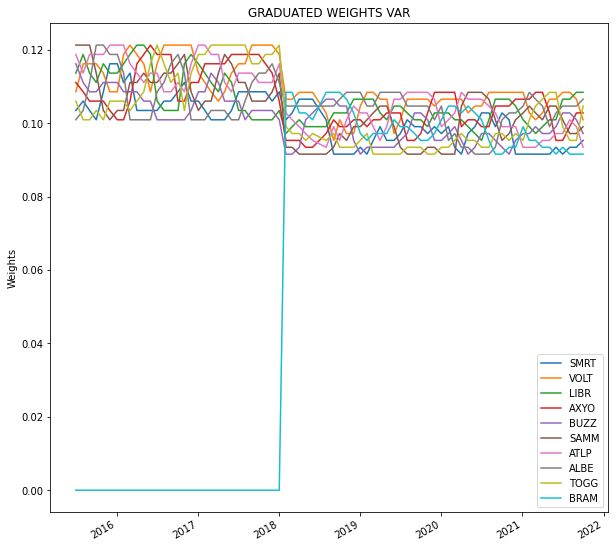

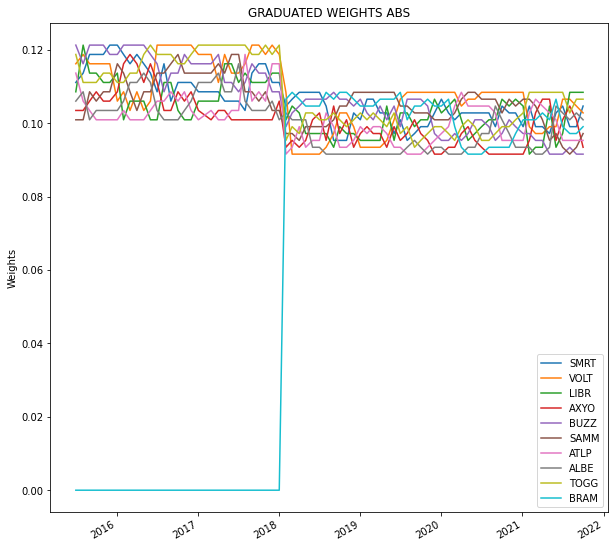

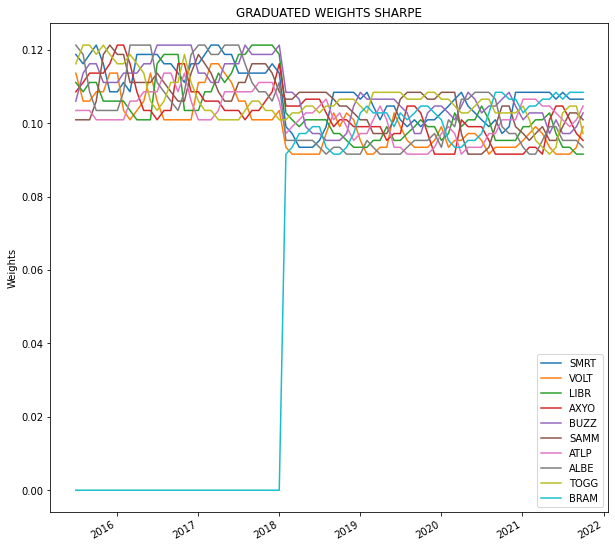

In [ ]:

lookback_months = 6
rebalancing_periods = 1

graduated_var_data = np.zeros(len(total_portfolio_index.columns))
graduated_abs_data = np.zeros(len(total_portfolio_index.columns))
graduated_sharpe_data = np.zeros(len(total_portfolio_index.columns))

graduated_weights_var = []
graduated_weights_abs = []
graduated_weights_sharpe = []

for date in [total_portfolio_index.index.min() + relativedelta(months=lookback_months) + relativedelta(months=month) for month in range(diff_month(total_portfolio_index.index.max(), total_portfolio_index.index.min() + relativedelta(months=lookback_months)))]:
  opt_slice = total_portfolio_rets.loc[(total_portfolio_rets.index < date) & (total_portfolio_rets.index >= date - relativedelta(months=lookback_months)), :].apply(lambda x: x + 1).cumprod()
  opt_slice = opt_slice.loc[:, opt_slice.std(axis=0) != 0]
  total_port_slice = total_portfolio_rets.loc[(total_portfolio_rets.index >= date) & (total_portfolio_rets.index < date + relativedelta(months=rebalancing_periods)), :]
  total_port_slice = total_port_slice.loc[:, opt_slice.columns].replace(np.inf, np.nan).replace(np.nan, 0)

  graduated_weight_var = np.array(list(map(lambda x: get_graduated_weights(z=x, b=len(opt_slice.columns)), [list(opt_slice.std().T.sort_values(ascending=False).index).index(col) for col in opt_slice.columns])))
  graduated_weight_abs = np.array(list(map(lambda x: get_graduated_weights(z=x, b=len(opt_slice.columns)), [list(opt_slice.iloc[-1, :].T.sort_values(ascending=False).index).index(col) for col in opt_slice.columns])))
  graduated_weight_sharpe = np.array(list(map(lambda x: get_graduated_weights(z=x, b=len(opt_slice.columns)), [list((opt_slice.iloc[-1, :] / opt_slice.std()) .T.sort_values(ascending=False).index).index(col) for col in opt_slice.columns])))

  graduated_weight_var = np.apply_along_axis(lambda x: x * 1 / sum(x), 0, graduated_weight_var)
  graduated_weight_abs = np.apply_along_axis(lambda x: x * 1 / sum(x), 0, graduated_weight_abs)
  graduated_weight_sharpe = np.apply_along_axis(lambda x: x * 1 / sum(x), 0, graduated_weight_sharpe)

  graduated_weights_var.append(pd.DataFrame(data=np.vstack([graduated_weight_var] * len(total_port_slice.index)), index=total_port_slice.index))
  graduated_weights_abs.append(pd.DataFrame(data=np.vstack([graduated_weight_abs] * len(total_port_slice.index)), index=total_port_slice.index))
  graduated_weights_sharpe.append(pd.DataFrame(data=np.vstack([graduated_weight_sharpe] * len(total_port_slice.index)), index=total_port_slice.index))

  graduated_var_rets = np.matmul(graduated_weight_var, total_port_slice.T.values)
  graduated_abs_rets = np.matmul(graduated_weight_abs, total_port_slice.T.values)
  graduated_sharpe_rets = np.matmul(graduated_weight_sharpe, total_port_slice.T.values)

  graduated_var_data = np.concatenate((graduated_var_data, graduated_var_rets))
  graduated_abs_data = np.concatenate((graduated_abs_data, graduated_abs_rets))
  graduated_sharpe_data = np.concatenate((graduated_sharpe_data, graduated_sharpe_rets))

for var_name in ['graduated_weights_var', 'graduated_weights_abs', 'graduated_weights_sharpe']:
  locals()[var_name] = pd.concat(locals()[var_name]).replace(np.nan, 0)
  locals()[var_name].columns = total_port_slice.columns
  locals()[var_name] = locals()[var_name].drop_duplicates()
  ax = locals()[var_name].plot(figsize=(10, 10))
  ax.set_ylabel("Weights")
  ax.set_title(' '.join(var_name.split('_')).upper())
  ax.plot()

[]

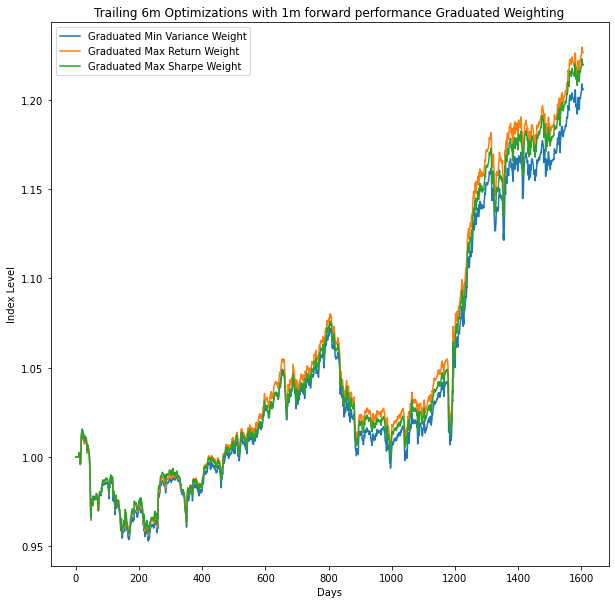

In [ ]:
graduated_var_data = pd.Series(graduated_var_data).rename('Graduated Min Variance Weight').replace(np.nan, 0).apply(lambda x: x + 1).cumprod()
graduated_abs_data = pd.Series(graduated_abs_data).rename('Graduated Max Return Weight').replace(np.nan, 0).apply(lambda x: x + 1).cumprod()
graduated_sharpe_data = pd.Series(graduated_sharpe_data).rename('Graduated Max Sharpe Weight').replace(np.nan, 0).apply(lambda x: x + 1).cumprod()

grad_lookahead_plot_df = pd.concat([graduated_var_data, graduated_abs_data, graduated_sharpe_data], axis=1)
grad_lookahead_plot_df.index.name = 'Days'

ax = grad_lookahead_plot_df.plot(figsize =(10, 10))
ax.set_ylabel("Index Level")
ax.set_title('Trailing 6m Optimizations with 1m forward performance Graduated Weighting')
plt.plot()

In [ ]:
grad_port_stats = pd.DataFrame()

for col, name in zip(grad_lookahead_plot_df.columns, ['Graduated Min Variance', 'Graduated Max Return', 'Graduated Max Sharpe']):
  grad_port_stats = pd.concat([grad_port_stats, get_port_stats(hist_data=grad_lookahead_plot_df.loc[:, col], col_label=name)], axis=1)

grad_port_stats.loc[['return', 'volatility', 'drawdown'], :] = (grad_port_stats.T.loc[:, ['return', 'volatility', 'drawdown']] * 100).values.T # scaling by return/vol/drawdown by 100 

grad_port_stats

,Graduated Min Variance,Graduated Max Return,Graduated Max Sharpe
return,2.977006,3.252037,3.159713
volatility,4.156552,4.121197,4.051100
sharpe,0.355344,0.425128,0.409694
sortino,0.479395,0.572315,0.561707
calmar,0.202327,0.248700,0.234812
drawdown,7.300108,7.044769,7.068263


**Platt Trader WDD Evaluation**

In [ ]:
# 6 month rolling window WDD evaluation
platt_mults = total_portfolio_index.rolling(window=22 * 6).apply(get_max_drawdown).apply(lambda x: x.apply(lambda y: (0 if y > .06 else 1/2) if y > .03 else 1))
# platt_mults = total_portfolio_index.rolling(window=22 * 6).apply(get_max_drawdown).apply(lambda x: x.apply(lambda y: 1/2 if y > .03 else 1))


Assuming equal weights and redistribution of laggard weights to leaders on trailing 6 month basis

[]

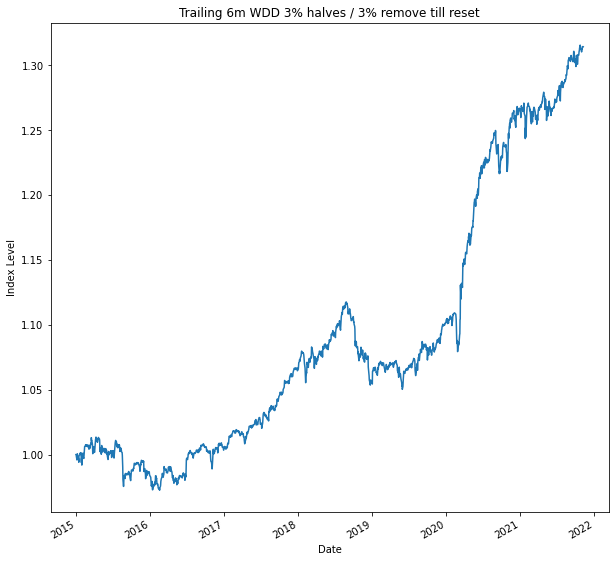

In [ ]:
platt_weights = pd.DataFrame(np.apply_along_axis(lambda x: x * (1 / sum(x)), 1, (platt_mults / len(platt_mults.columns)).values)).apply(
    lambda x: x.apply(lambda y: min(.3, y) if re.search('SMRT|VOLT|LIBR', str(x.name), re.I) else min(.15, y))) # cap of 50%/30% for any internal/external strategy weight 

platt_weights.columns = platt_mults.columns
platt_performance = pd.Series(data = (platt_weights *  total_portfolio_rets.values).sum(axis=1).apply(lambda x: x + 1).cumprod().values, index=platt_mults.index)
platt_performance.rename('Platt 3% Rule')
platt_performance.index.name = 'Date'
ax = platt_performance.plot(figsize=(10, 10))
ax.set_ylabel("Index Level")
ax.set_title('Trailing 6m WDD 3% halves / 3% remove till reset')
plt.plot()

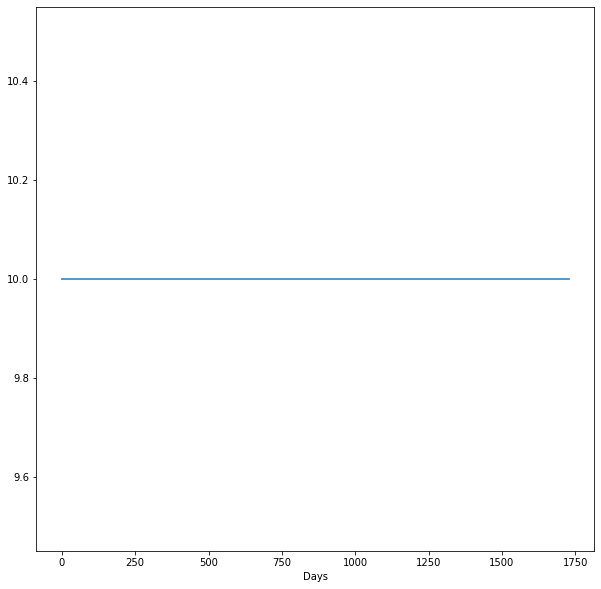

In [ ]:
platt_strats_allocated = pd.Series(data=np.apply_along_axis(func1d=lambda x: len(x[x != 0]), axis=1, arr=platt_weights), index=platt_weights.index)
platt_strats_allocated.index.name = 'Days'
platt_strats_allocated = platt_strats_allocated.rename(f'Number of Strats Allocated out of {len(platt_weights.columns)}', inplace=False)
platt_strats_allocated.plot(figsize=(10, 10))

concentration_risk single-strat above 25%: 0.0%
operational strategies all: 100.0%


[]

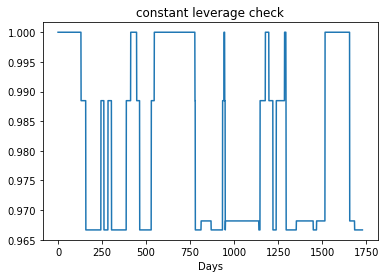

In [ ]:
print(f'concentration_risk single-strat above 25%: {round(100 * len(platt_weights.max(axis=1)[platt_weights.max(axis=1) > .25]) / len(platt_weights), 2)}%')
print(f'operational strategies all: {100 * round(len(platt_weights[platt_weights != 0 ].dropna()) / len(platt_weights), 2)}%')
ax = platt_weights.sum(axis=1).plot()
ax.set_title('constant leverage check')
plt.plot()

In [ ]:
platt_port_stats = get_port_stats(hist_data=platt_performance, col_label='Platt Method')
platt_port_stats.loc[['return', 'volatility', 'drawdown'], :] = (platt_port_stats.T.loc[:, ['return', 'volatility', 'drawdown']] * 100).values.T # scaling by return/vol/drawdown by 100 

platt_port_stats

,Platt Method
return,3.927530
volatility,3.589370
sharpe,0.676311
sortino,0.944741
calmar,0.402698
drawdown,6.028168


**Leverage Determination**

In [ ]:
# Setting quantile calculation at 6 slices
# Maximum leverage set at 5x

n_components = 6
max_lev = 5

allocated_weights = platt_weights.iloc[1:, :] 
allocated_weights = pd.concat([gmv_weights, pd.DataFrame(index=platt_performance.loc[platt_performance.index >= gmv_weights.index.min()].index.difference(gmv_weights.index))], axis=0).sort_index(ascending=True).ffill()

allocated_rets = platt_performance.pct_change().dropna() 
allocated_rets = pd.Series(data=gmv_data.pct_change().dropna().iloc[2:].values, index=allocated_weights.index)
 

Text(0.5, 1.0, '3-month 3m trailing correlation')

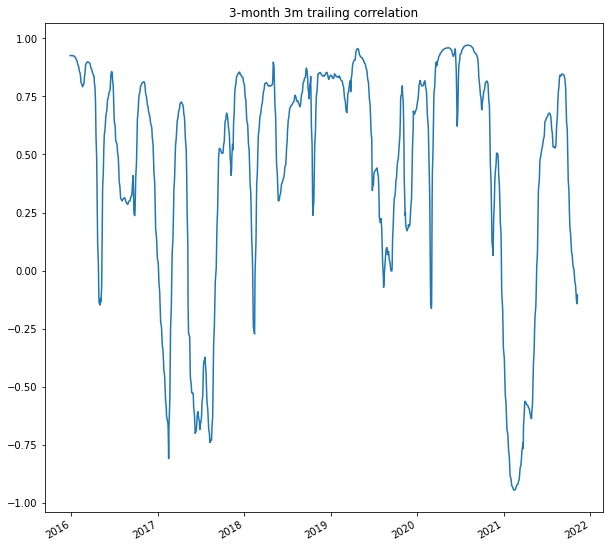

In [ ]:
roll_len = 21 * 3 # 3 months worth of trading days

ax = pd.concat([allocated_rets.rolling(window=roll_len).std().rename('Platt'), sp_index.pct_change().dropna().rolling(window=roll_len).std()], axis=1).dropna().rolling(roll_len).corr().unstack().iloc[:, 1].dropna().plot(figsize=(10, 10))
ax.set_title('3-month 3m trailing correlation')

*Hidden Markov Model (HMM) Leverage Determination*






In [ ]:


def hmm_apply(arr: np.array):
  try:
    model = GaussianHMM(n_components=n_components, covariance_type='full',n_iter=1000).fit(arr.values.reshape(-1, 1))
    return model.predict(arr.iloc[-1].reshape(-1, 1))
  except ValueError:
    return 0

roll_hmm_frame = allocated_rets.shift(1).replace([np.inf, -np.inf], np.nan, inplace=False).dropna()

hmm_preds = roll_hmm_frame.rolling(window = 12 * 21).apply(hmm_apply)
                                  

Text(0.5, 1.0, 'Hidden Markov Model det Leverage with Platt Allocation Rules')

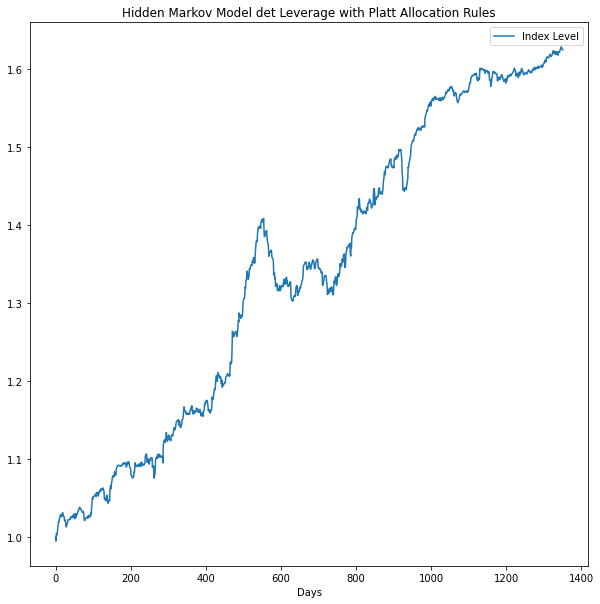

In [ ]:
hmm_lev_perf = pd.DataFrame(hmm_preds.apply(lambda x: (x + 1) * max_lev / (n_components + 1)).values * allocated_rets.iloc[1:]).dropna().apply(lambda x: x + 1).cumprod().reset_index(inplace=False, drop=True)
hmm_lev_perf.index.name = 'Days'
hmm_lev_perf.columns = ['Index Level']
ax = hmm_lev_perf.plot(figsize=(10, 10))
ax.set_title('Hidden Markov Model det Leverage with Platt Allocation Rules')

In [ ]:
get_port_stats(hist_data=hmm_lev_perf, col_label='HMM Platt')


,HMM Platt
return,0.094762
volatility,0.045591
sharpe,1.749520
sortino,2.287606
calmar,1.060235
drawdown,0.075230


Turnover percentage: 0.5769230769230769
Mean Leverage: 2.0949810177657766


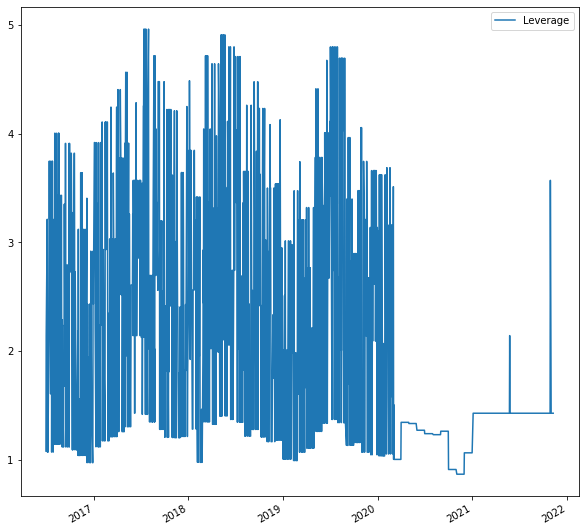

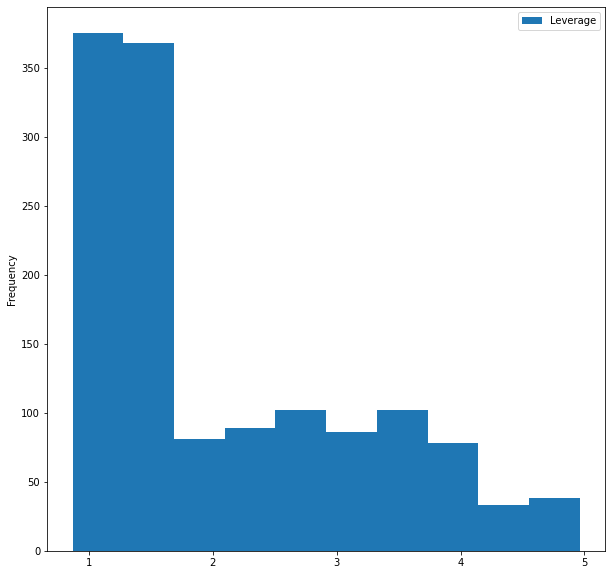

In [ ]:
hmm_plat_lev = pd.DataFrame(data=np.apply_along_axis(lambda x: (x + 1) * allocated_weights.iloc[1:, ].sum(axis=1) * max_lev / (n_components + 1), 0, (hmm_preds.values + 1)) , index=roll_hmm_frame.iloc[-len(hmm_preds):, ].index, columns=['Leverage']).dropna()
hmm_plat_lev.plot(figsize=(10, 10))

print(f'Turnover percentage: {len(hmm_plat_lev.diff().dropna()[hmm_plat_lev.diff().dropna() != 0].dropna()) / len(hmm_plat_lev.diff())}')

hmm_plat_lev.plot.hist(figsize=(10, 10))
print(f'Mean Leverage: {hmm_plat_lev.mean().values[0]}')

*Gaussian Naive-Bayes Leverage Determination*

Check for Gaussian Similarity

Text(0, 0.5, 'frequency')

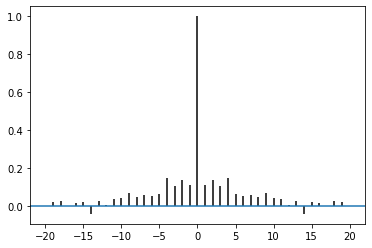

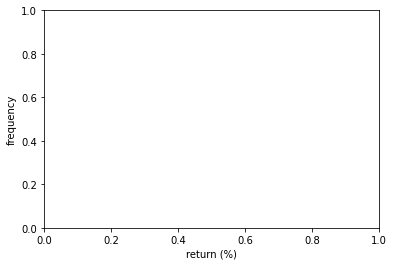

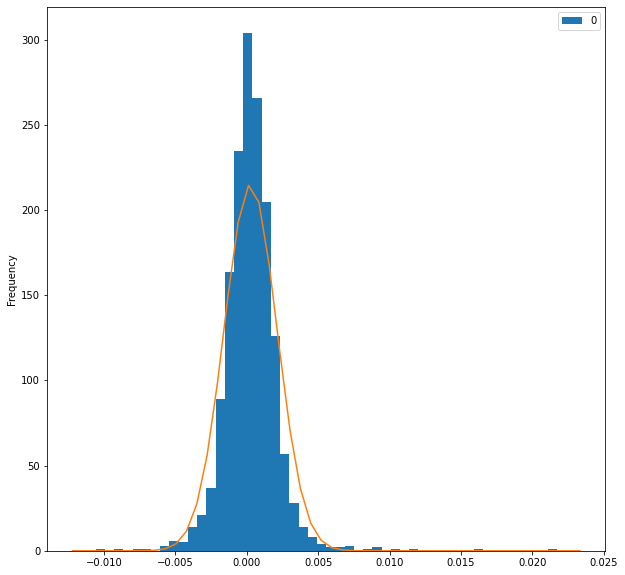

In [ ]:
plt.acorr(allocated_rets, maxlags=20)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("return (%)")

_ = pd.DataFrame(allocated_rets).plot.hist(bins=min(50, len(allocated_rets)), figsize=(10, 10))

mu, std = norm.fit(allocated_rets)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, min(50, len(allocated_rets)))
plt.plot(x, norm.pdf(x, mu, std))
ax.set_ylabel('frequency')

Monte Carlo Simulation of Gaussian Native-Bayes Random Portfolio Evolution

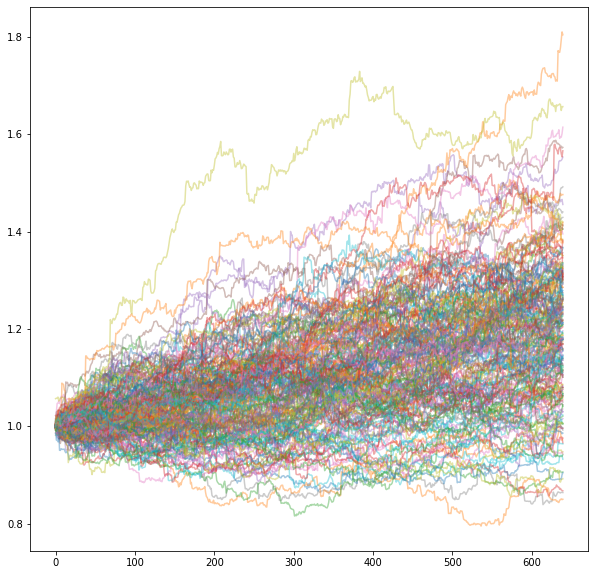

In [ ]:


# features = pd.DataFrame(allocated_weights.values * total_portfolio_rets.values).shift(1).iloc[1:, :]



features = pd.concat([pd.DataFrame(allocated_weights.values * total_portfolio_rets.loc[total_portfolio_rets.index >= allocated_rets.index.min(), :].values).shift(n) for n in range(1, 5)], axis=1)
features.columns = [n for n in range(len(features.columns))]
features = features.dropna().shift(1).dropna()

raw_targets = allocated_rets.iloc[features.index.min():,]


encoder = KBinsDiscretizer(n_bins=max_lev, encode='ordinal', strategy='quantile').fit(raw_targets.abs().to_numpy().reshape(-1, 1))
encoded_targets = encoder.transform(raw_targets.abs().to_numpy().reshape(-1, 1))
targets = pd.DataFrame(encoded_targets).apply(lambda x: x + 1)


mc_trials = []
mc_weights_nb_gauss = []


for n in range(201):

  train_features, test_features = train_test_split(features, random_state=n, test_size=.4, shuffle=True)
  train_raw_targets, test_raw_targets = train_test_split(raw_targets, random_state=n, test_size=.4, shuffle=True)
  train_targets, test_targets = train_test_split(targets, random_state=n, test_size=.4, shuffle=True)

  model = GaussianNB()

  model.fit(train_features, train_targets)

  oos_preds = model.predict(test_features)

  test_raw_targets.iloc[pd.Series(oos_preds).diff()[pd.Series(oos_preds).diff() != 0].index] -= .0001 # 1bps position change accountability

  mc_lev_perf = pd.Series((oos_preds * test_raw_targets).apply(lambda x: x + 1).cumprod().values)

  ax = mc_lev_perf.plot(figsize=(10, 10), alpha=.4)

  mc_trials.append(mc_lev_perf.values)
  mc_weights_nb_gauss.append(oos_preds)




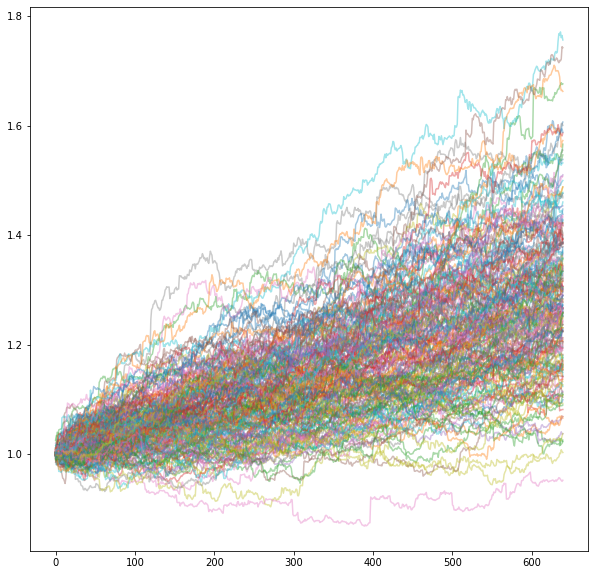

In [ ]:
mc_trials = []
mc_weights_nb_gauss = []


for n in range(201):

  train_features, test_features = train_test_split(features, random_state=n, test_size=.4, shuffle=True)
  train_raw_targets, test_raw_targets = train_test_split(raw_targets, random_state=n, test_size=.4, shuffle=True)
  train_targets, test_targets = train_test_split(targets, random_state=n, test_size=.4, shuffle=True)

  model = GaussianNB()

  model.fit(train_features, train_targets)

  oos_preds = model.predict(test_features)

  test_raw_targets.iloc[pd.Series(oos_preds).diff()[pd.Series(oos_preds).diff() != 0].index] -= .0001 # 1bps position change accountability

  mc_lev_perf = pd.Series((np.apply_along_axis(lambda x: max_lev / x, 0, oos_preds) * test_raw_targets).apply(lambda x: x + 1).cumprod().values)

  ax = mc_lev_perf.plot(figsize=(10, 10), alpha=.4)
  
  mc_trials.append(mc_lev_perf.values)
  mc_weights_nb_gauss.append(oos_preds)




Text(0, 0.5, 'Rolling 1m leverage')

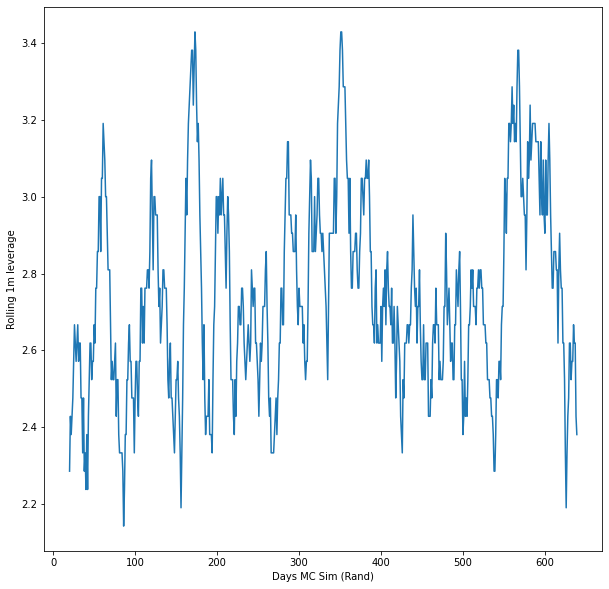

In [ ]:
median_mc_nb_gauss_lev = pd.Series(data = mc_weights_nb_gauss[list(np.array(mc_trials)[:, -1]).index(np.median(np.array(mc_trials)[:, -1]))]).rolling(window=21).mean()
median_mc_nb_gauss_lev.rename('Median MC Sim Leverage')
median_mc_nb_gauss_lev.index.name = 'Days MC Sim (Rand)'

ax = median_mc_nb_gauss_lev.plot(figsize=(10, 10))
ax.set_ylabel('Rolling 1m leverage')
                                      

In [ ]:
mc_df = pd.concat([get_port_stats(hist_data=pd.DataFrame(np.average(mc_trials, axis=0)), col_label='Monte Carlo Avg'),
           get_port_stats(hist_data=pd.DataFrame(np.max(mc_trials, axis=0)), col_label='Monte Carlo Max'),
           get_port_stats(hist_data=pd.DataFrame(np.min(mc_trials, axis=0)), col_label='Monte Carlo Min'),
           get_port_stats(hist_data=pd.DataFrame(np.median(mc_trials,axis=0)), col_label='Monte Carlo Median')], axis=1)

mc_df.loc[['return', 'volatility', 'drawdown'], :] = (mc_df.T.loc[:, ['return', 'volatility', 'drawdown']] * 100).values.T # scaling by return/vol/drawdown by 100 

mc_df.iloc[:, 1:]

,Monte Carlo Max,Monte Carlo Min,Monte Carlo Median
return,23.598927,-1.333143,10.103744
volatility,7.179055,6.870357,2.328059
sharpe,3.078250,-0.412372,3.695673
sortino,5.277305,-0.510897,6.155915
calmar,4.975639,-0.239073,9.809690
drawdown,4.441425,11.850561,0.877066


OOS Non-Random Guassian Naive-Bayes Simulation


Text(0, 0.5, 'Index Level')

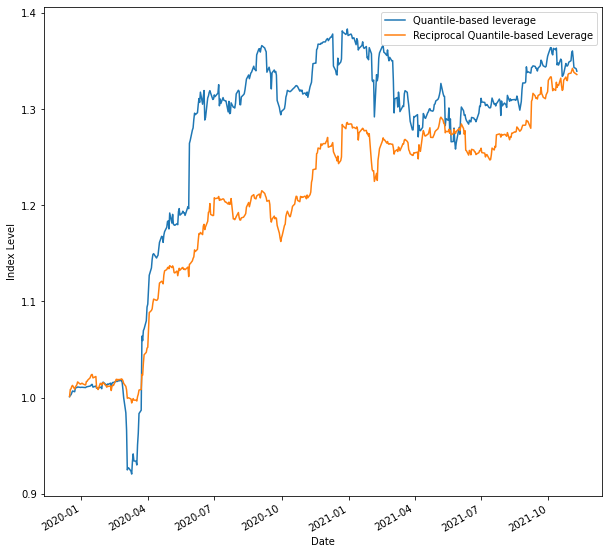

In [ ]:
train_features, test_features = train_test_split(features, test_size=.3, shuffle=False)
train_raw_targets, test_raw_targets = train_test_split(raw_targets, test_size=.3, shuffle=False)
train_targets, test_targets = train_test_split(targets, test_size=.3, shuffle=False)

model = GaussianNB()
model.fit(train_features, train_targets)

oos_preds = model.predict(test_features)

test_raw_targets.iloc[pd.Series(oos_preds).diff()[pd.Series(oos_preds).diff() != 0].index] -= .0001

nb_gauss_lev_perf = pd.concat([pd.Series((oos_preds * test_raw_targets).apply(lambda x: x + 1).cumprod().values), 
                               pd.Series((np.apply_along_axis(lambda x: max_lev / x, 0, oos_preds) * test_raw_targets).apply(lambda x: x + 1).cumprod().values)], axis=1)


nb_gauss_lev_perf.columns = ['Quantile-based leverage', 'Reciprocal Quantile-based Leverage']
nb_gauss_lev_perf.index = test_raw_targets.index
nb_gauss_lev_perf.index.name = 'Date'
ax = nb_gauss_lev_perf.plot(figsize=(10, 10))
ax.set_ylabel('Index Level')

Text(0, 0.5, 'Rolling 1m leverage')

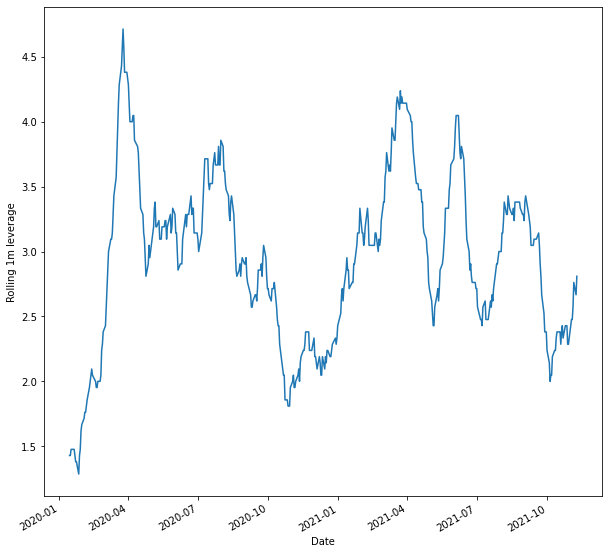

In [ ]:
test_nb_gauss_lev = pd.Series(data=oos_preds, index=test_raw_targets.index).rolling(window=21).mean()
test_nb_gauss_lev.rename('OOS Non-Shuffled NB Gauss Leverage')
test_nb_gauss_lev.index.name = 'Date'

ax = test_nb_gauss_lev.plot(figsize=(10, 10))
ax.set_ylabel('Rolling 1m leverage')


In [ ]:
print(f'Percent of turnover time: {len(pd.DataFrame(oos_preds).diff()[pd.DataFrame(oos_preds).diff().dropna() != 0].dropna()) / len(pd.Series(oos_preds).diff())}')

Percent of turnover time: 0.6083333333333333


In [ ]:
nb_gauss_lev_perf_port_stats = pd.concat([get_port_stats(hist_data=nb_gauss_lev_perf.iloc[:, 0], col_label='NB Gauss Quantile Leverage'),
           get_port_stats(hist_data=nb_gauss_lev_perf.iloc[:, 0][nb_gauss_lev_perf.index > dt.datetime(2021,6, 1)],  col_label='NB Gauss Quantile Leverage Live Results'),
           get_port_stats(hist_data=nb_gauss_lev_perf.iloc[:, 1], col_label='NB Gauss Reciprocal Quantile Leverage'),
           get_port_stats(hist_data=nb_gauss_lev_perf.iloc[:, 1][nb_gauss_lev_perf.index > dt.datetime(2021,6, 1)],  col_label='NB Gauss Reciprocal Quantile Leverage Live Results')], axis=1)

nb_gauss_lev_perf_port_stats.loc[['return', 'volatility', 'drawdown'], :] = (nb_gauss_lev_perf_port_stats.T.loc[:, ['return', 'volatility', 'drawdown']] * 100).values.T # scaling by return/vol/drawdown by 100 

nb_gauss_lev_perf_port_stats.iloc[:, 2:]

,NB Gauss Reciprocal Quantile Leverage,NB Gauss Reciprocal Quantile Leverage Live Results
return,15.785780,10.358712
volatility,6.918216,6.225650
sharpe,2.064951,1.422938
sortino,3.010472,2.182995
calmar,2.994506,3.040202
drawdown,4.770663,2.913856


In [ ]:
train_features, test_features = train_test_split(total_portfolio_rets.values, shuffle=False, test_size=.3)


var_treshold = .85
pca = PCA(var_treshold)
pca.fit(train_features)
print(pca.explained_variance_)
prin_comp = pca.components_

norm_comps = np.array([eigen_vector / eigen_vector.sum() for eigen_vector in prin_comp])

num_comps = np.where(np.logical_not(np.cumsum(pca.explained_variance_ratio_) < var_treshold))[0][0] + 1

# train_features, test_features = pca.transform(train_features), pca.transform(test_features)


[9.20613371e-05 5.28922135e-05 4.23854151e-05 2.93356323e-05
 2.65203978e-05 2.34063121e-05]


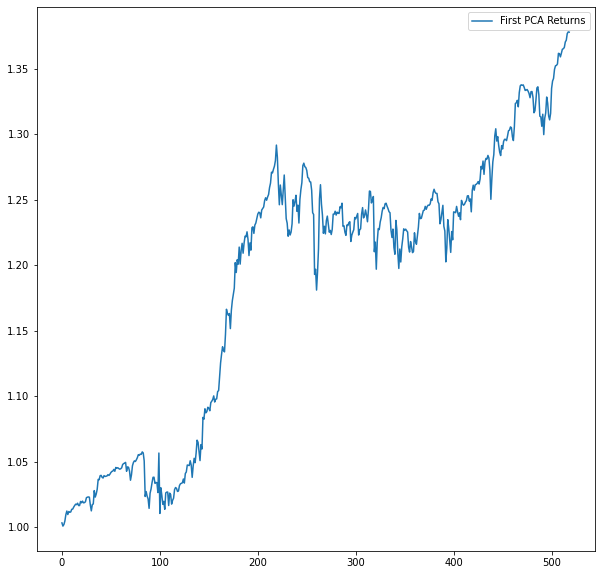

In [ ]:
pca_rets = pd.DataFrame((test_features * norm_comps[:num_comps][0]).sum(axis=1)).apply(lambda x: x + 1).cumprod()
pca_rets.columns = ['First PCA Returns']
pca_rets.plot(figsize=(10, 10))


In [ ]:
get_port_stats(hist_data=pca_rets, col_label='First PCA')

,First PCA
return,0.166688
volatility,0.110878
sharpe,1.368064
sortino,1.623616
calmar,1.769252
drawdown,0.085736


In [ ]:

roll_len = 21 * 6
def _apply_pca(arr: np.array, roll_len: int):
  if arr.shape[0] < roll_len:
    return np.empty(arr.shape[1]) * np.nan
  else:
    pca = PCA(.85)
    pca.fit(arr) 
    # LogisticRegression().fit(pca.transform)
    return sum(pca.components_)

factor_loadings: np.array = np.stack([
    _apply_pca(arr=PortfolioOptimization(hist_data=total_portfolio_rets.iloc[n - roll_len:n, :].values, roll_len=roll_len) for n in range(total_portfolio_rets.shape[0])])

pd.DataFrame(factor_loadings * total_portfolio_rets.values).sum(axis=1).apply(lambda x: x +1).cumprod().plot()

In [ ]:
# No negative weights and cap at 50% for all external models gross exposure applied to closed form solutions
# Best ranked strategies on a trailing basis, graduated weighting
# Michael Platt strict method 
# PCA optimal weighting
# Hidden Markov Chain for regime detection
# Kelly Criterion 
# Factor model for determining strategy weights
# How certain rules affect the psychology of individual traders (from a practice perspective)
